In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [2]:
Image('wheel_encoders.png')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In a differential-drive model, we discussed the relation between wheel velocities and robot's rotational and translational velocity, i.e, $v, \omega$. 

If we need to know curent $v, \omega$ how to measure wheel velocities? We use wheel encoders

Encoder resolution = $N$

Every $\Delta T$ ms,
+ Encoder reports # ticks wheel moved = $n$
+ Angle moved = $2\pi \frac{n}{N}$

Usage
+ Smallest movement that can be measured is $\frac{2\pi}{N}$
+ Largest speed that can be measured is $\frac{2\pi}{\Delta T}$

Pros:
+ Fairly accurate estimates of linear/ angular velocity
+ Distances and rotations are accurate in short-term

Cons:
+ Vehicle position “drifts” when $v,\omega$ is integrated over longer periods

Say, your robot's initial pose is (0.0, 0.0, 0.0), write a program to accept left and right ticks as input and output the next pose

Assume an unicycle model and following vehicle parameters
+ Wheel radius ($r$) =  2.0m
+ Track-width ($L$) = 4.0m
+ Encoder ticks ($N$) = 100 
+ Encoder frequency ($\Delta T$) = 0.1

Test your code with $n_{right} = 10$ and $N_{left} = 6$. Do you get the next pose as $(1.0053, 0.0, 0.1257)$?

In [4]:
def unicycle_model(curr_pose, v, w, dt=1.0):
    ## write code to calculate next_pose
    # refer to the kinematic equations of a unicycle model
    x = curr_pose[0] + v*np.cos(curr_pose[2])*dt 
    y = curr_pose[1] + v*np.sin(curr_pose[2])*dt 
    theta = curr_pose[2] + w*dt 
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
    return (x, y, theta)

In [5]:
def output_pose(nleft, nright):
  rad = 2
  L = 4
  N = 100
  wr = 2*np.pi*(nright)/N 
  wl = 2*np.pi*(nleft)/N
  w = (rad/L)*(wr - wl)
  v = (rad/2)*(wr + wl)
  pose = unicycle_model([0,0,0],v,w)
  return pose

In [6]:
output_pose(6,10)

(1.0053096491487339, 0.0, 0.12566370614359174)

### Effect of angular error in pose estimate

In [9]:
initial_error = np.deg2rad(1.0)
robot_pose = np.array([0, 0, np.pi/2 + initial_error])

In [10]:
# write your code to simulate straight line motion 
# robot can be assumed to be moving at constant speed of 2 m/s for 30 seconds
# feel free to borrow code from your previous notebooks
#straight line
straight_trajectory = []
steps = 10
#fill in v and omega values
v = np.ones(steps)
w = np.zeros(steps)
for i in range(steps):
   #instruction to take v, w and compute new pose    
    straight_trajectory.append(robot_pose) 
    robot_pose = unicycle_model(robot_pose,v[i],w[i])
   # store new pose
straight_trajectory = np.array(straight_trajectory) 
print(60 * np.tan(np.deg2rad(1)))

1.0473038956930552


If there was no initial angle error, robot will end up at $x$ = 0.0. 

Plot a graph between initial_error and final $x$ position?

Text(0, 0.5, 'Final x position')

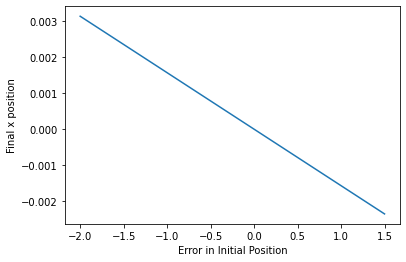

In [31]:
x_final = []
for i in range(0, 8):
  err = np.arange(-2,2,0.5)
  initial_error = np.deg2rad(err[i])
  robot_pose = np.array([0, 0, np.pi/2 + initial_error])
  straight_trajectory = []
  steps = 10
  #fill in v and omega values
  v = np.ones(steps)
  w = np.zeros(steps)
  for i in range(steps):
   #instruction to take v, w and compute new pose    
    straight_trajectory.append(robot_pose) 
    robot_pose = unicycle_model(robot_pose,v[i],w[i])
   # store new pose
  straight_trajectory = np.array(straight_trajectory) 
  ### Plot straight 
  xf, yf, _ = straight_trajectory[-1]
  x_final.append(xf)
plt.figure()
plt.plot(err, x_final)
plt.xlabel('Error in Initial Position')
plt.ylabel('Final x position')


### Demonstrate localization drift in wheel encoders

### Synthetic dataset

In [11]:
all_v = np.ones(100)
all_w = np.zeros(100) 

In [12]:
wheel_enc_traj, wheel_enc_traj_noisy = [], []
ideal_pose = np.array([0, 0, np.pi/2])
noisy_pose = np.array([0, 0, np.pi/2])

for v, w in zip(all_v, all_w):
    wheel_enc_traj.append(ideal_pose)
    wheel_enc_traj_noisy.append(noisy_pose)
    #code to update ideal_pose
    ideal_pose = unicycle_model(ideal_pose,v,w)
    
    #code to update noisy pose
    #add gaussian noise with std dev of 0.01 to omega
    noisy_pose = unicycle_model(noisy_pose,v,w+np.random.normal(0, 0.01, w.shape))
    
robot_traj = np.array(wheel_enc_traj)
robot_traj_noisy = np.array(wheel_enc_traj_noisy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
No handles with labels found to put in legend.


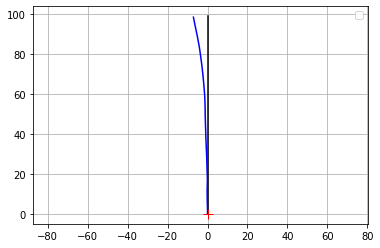

In [14]:
plt.figure()
plt.grid()
plt.axes().set_aspect("equal","datalim")
plt.plot(robot_traj[:,0], robot_traj[:,1],'k-')
plt.plot(robot_traj_noisy[:,0], robot_traj_noisy[:,1],'b-')
plt.plot(0, 0, 'r+', ms=10)
plt.legend()

### Real dataset

In [16]:
!ls

drive  sample_data


In [18]:
data_dir = "/content/drive/MyDrive/Week-1 Assignment LABLET AP102/data"
ground_truth = pd.read_csv(data_dir + "/ground_truth.csv")
gt_traj = np.array(ground_truth[['x','y']])
wheel_enc = np.array(pd.read_csv(data_dir + "/wheel_control.csv")[['v','w']])

In [19]:
def unicycle_model(pose, v, w, dt = 0.01):
  x, y, theta = pose
  x += v*np.cos(theta)*dt
  y += v*np.sin(theta)*dt
  theta += w*dt
  theta = np.arctan2(np.sin(theta), np.cos(theta))
  return x, y, theta

In [21]:
pose = np.array(ground_truth[['x','y','theta']])[0] #initial pose
robot_traj = []
for v, w in wheel_enc:
    robot_traj.append(pose)
    # code for updating pose
    pose = unicycle_model(pose, v, w)
robot_traj = np.array(robot_traj)

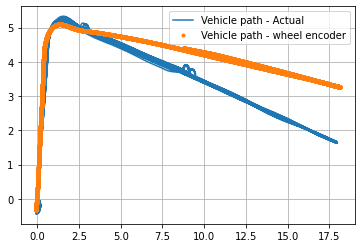

In [23]:
end = 10000
plt.figure()
plt.grid()
plt.plot(gt_traj[:,0], gt_traj[:,1], label='Vehicle path - Actual')
plt.plot(robot_traj[:end,0], robot_traj[:end,1], '.', label='Vehicle path - wheel encoder')
plt.legend()